#### Ibrahim Johar Farooqi
#### 23K-0074
#### ML - Lab 04 - Tasks

#### task 02

In [2]:
import numpy as np
import pandas as pd
from math import log2

df = pd.read_csv('task2.csv')
target = "CLASS(Yes or No)"


#calc entropy for a given pandas series (target labels)
def entropy(column):
    probs = column.value_counts(normalize=True)
    ent = 0
    for p in probs:
        if p > 0:
            ent -= p * log2(p)
    return ent

def information_gain(df, attribute, target, show_steps=False):
    total_entropy = entropy(df[target]) #entropy before the split
    weighted_entropy = 0.0              #initialize weighted entropy
    details = {}

    #loop thru each unique value of the attribute
    for value in df[attribute].unique():
        subset = df[df[attribute] == value]       #subset where attribute == value
        weight = len(subset) / len(df)            #proportion of subset
        ent = entropy(subset[target])             #entropy of subset
        weighted_entropy += weight * ent          #accumulate weighted entropy
        details[value] = {"samples": len(subset), "weight": weight, "entropy": ent}

    #calc final information gain
    ig = total_entropy - weighted_entropy

    return ig

print(f"overall entropy of the dataset = {entropy(df[target]):.3f}\n")

attributes = [col for col in df.columns if col not in [target, "ID"]]
ig_results = {}

for attr in attributes:
    ig_value = information_gain(df, attr, target)
    ig_results[attr] = ig_value
    
#sort attributes
sorted_ig = sorted(ig_results.items(), key=lambda x: x[1], reverse=True)

print("information gain for all attributes:\n")
for attr, score in sorted_ig:
    print(f"{attr:<20} : IG = {score:.4f}") 
    
root_feature = sorted_ig[0][0]
print(f"\nroot node (highest IG) is: {root_feature}")

overall entropy of the dataset = 0.971

information gain for all attributes:

OWNS_HOUSE           : IG = 0.4200
CREDIT_RATING        : IG = 0.3630
JOB_STATUS           : IG = 0.3237
AGE                  : IG = 0.0830

root node (highest IG) is: OWNS_HOUSE


#### task 03

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import sklearn 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("cancer patient data sets.csv")

df.head()

,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1000 non-null   int64 
 1   Patient Id                1000 non-null   object
 2   Age                       1000 non-null   int64 
 3   Gender                    1000 non-null   int64 
 4   Air Pollution             1000 non-null   int64 
 5   Alcohol use               1000 non-null   int64 
 6   Dust Allergy              1000 non-null   int64 
 7   OccuPational Hazards      1000 non-null   int64 
 8   Genetic Risk              1000 non-null   int64 
 9   chronic Lung Disease      1000 non-null   int64 
 10  Balanced Diet             1000 non-null   int64 
 11  Obesity                   1000 non-null   int64 
 12  Smoking                   1000 non-null   int64 
 13  Passive Smoker            1000 non-null   int64 
 14  Chest Pain               

In [6]:
df.columns

Index(['index', 'Patient Id', 'Age', 'Gender', 'Air Pollution', 'Alcohol use',
       'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk',
       'chronic Lung Disease', 'Balanced Diet', 'Obesity', 'Smoking',
       'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue',
       'Weight Loss', 'Shortness of Breath', 'Wheezing',
       'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold',
       'Dry Cough', 'Snoring', 'Level'],
      dtype='object')

In [7]:
df.describe()

,index,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Coughing of Blood,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring
count,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,37.174000,1.402000,3.8400,4.563000,5.165000,4.840000,4.580000,4.380000,4.491000,...,4.859000,3.856000,3.855000,4.240000,3.777000,3.746000,3.923000,3.536000,3.853000,2.926000
std,288.819436,12.005493,0.490547,2.0304,2.620477,1.980833,2.107805,2.126999,1.848518,2.135528,...,2.427965,2.244616,2.206546,2.285087,2.041921,2.270383,2.388048,1.832502,2.039007,1.474686
min,0.000000,14.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,249.750000,27.750000,1.000000,2.0000,2.000000,4.000000,3.000000,2.000000,3.000000,2.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,499.500000,36.000000,1.000000,3.0000,5.000000,6.000000,5.000000,5.000000,4.000000,4.000000,...,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,749.250000,45.000000,2.000000,6.0000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,...,7.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,4.000000
max,999.000000,73.000000,2.000000,8.0000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,...,9.000000,9.000000,8.000000,9.000000,8.000000,8.000000,9.000000,7.000000,7.000000,7.000000


In [8]:
df.dtypes

index                        int64
Patient Id                  object
Age                          int64
Gender                       int64
Air Pollution                int64
Alcohol use                  int64
Dust Allergy                 int64
OccuPational Hazards         int64
Genetic Risk                 int64
chronic Lung Disease         int64
Balanced Diet                int64
Obesity                      int64
Smoking                      int64
Passive Smoker               int64
Chest Pain                   int64
Coughing of Blood            int64
Fatigue                      int64
Weight Loss                  int64
Shortness of Breath          int64
Wheezing                     int64
Swallowing Difficulty        int64
Clubbing of Finger Nails     int64
Frequent Cold                int64
Dry Cough                    int64
Snoring                      int64
Level                       object
dtype: object

In [9]:
df.shape

(1000, 26)

In [10]:
df.isnull().sum()

index                       0
Patient Id                  0
Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64

In [11]:
df = df.dropna(axis=1, how='all')   #drop columns which are all NaN
dup_count = df.duplicated().sum()

if dup_count > 0:
    df = df.drop_duplicates()

#drop rows with any missing values
missing_before = df.isna().sum().sum()
df = df.dropna()
missing_after = df.isna().sum().sum()

print(f"duplicates dropped: {dup_count}")
print(f"missing vals before: {missing_before}, after dropna: {missing_after}")
print("cleaned shape:", df.shape)

duplicates dropped: 0
missing vals before: 0, after dropna: 0
cleaned shape: (1000, 26)


dropped fully-empty columns and duplicate rows, then removed any rows with missing values. if many rows were lost, a more careful imputation strategy could be used instead like (mean/median or model-based).

In [12]:
#checks class balance(the target variable’s distribution)
#if all classes appear roughly equally, the dataset is balanced. "normalize=True" gives proportions instead of counts.
df['Level'].value_counts(normalize=True) 

Level
High      0.365
Medium    0.332
Low       0.303
Name: proportion, dtype: float64

In [13]:
#finding categorical cols (both object and category types)
df.select_dtypes(include=['category', 'object'])

,Patient Id,Level
0,P1,Low
1,P10,Medium
2,P100,High
3,P1000,High
4,P101,High
...,...,...
995,P995,High
996,P996,High
997,P997,High
998,P998,High


In [14]:
#converting target column 'Level' from text label to numeric
#label encoding
df['Level'] = df['Level'].astype('category').cat.codes

In [15]:
df.dtypes

index                        int64
Patient Id                  object
Age                          int64
Gender                       int64
Air Pollution                int64
Alcohol use                  int64
Dust Allergy                 int64
OccuPational Hazards         int64
Genetic Risk                 int64
chronic Lung Disease         int64
Balanced Diet                int64
Obesity                      int64
Smoking                      int64
Passive Smoker               int64
Chest Pain                   int64
Coughing of Blood            int64
Fatigue                      int64
Weight Loss                  int64
Shortness of Breath          int64
Wheezing                     int64
Swallowing Difficulty        int64
Clubbing of Finger Nails     int64
Frequent Cold                int64
Dry Cough                    int64
Snoring                      int64
Level                         int8
dtype: object

In [16]:
#computing the pearson correlation matrix (for numeric cols)
corr = df.corr(method='pearson', numeric_only=True)
target_corr = corr['Level'].drop('Level')

print(f"corr w/ target:\n{target_corr.sort_values(ascending=True)}")

corr w/ target:
Passive Smoker             -0.638409
Coughing of Blood          -0.631118
Balanced Diet              -0.618781
Smoking                    -0.611087
Air Pollution              -0.577269
Obesity                    -0.561961
Chest Pain                 -0.494704
Alcohol use                -0.434071
chronic Lung Disease       -0.432405
Genetic Risk               -0.423382
Fatigue                    -0.403276
OccuPational Hazards       -0.363748
Dust Allergy               -0.264926
Dry Cough                  -0.228720
Frequent Cold              -0.171678
Shortness of Breath        -0.140178
index                      -0.024556
Weight Loss                -0.020537
Swallowing Difficulty      -0.012880
Snoring                     0.014280
Age                         0.042631
Gender                      0.086222
Clubbing of Finger Nails    0.116746
Wheezing                    0.167773
Name: Level, dtype: float64


In [ ]:
#feature selection using correlation
#helps simplify the model by removing weakly related features, reducing noise
threshold = 0.2
selected_features = target_corr[abs(target_corr) >= threshold].index
print(f"selected features (|r|>=0.2):\n{selected_features}")

selected features (|r|>=0.2):
Index(['Air Pollution', 'Alcohol use', 'Dust Allergy', 'OccuPational Hazards',
       'Genetic Risk', 'chronic Lung Disease', 'Balanced Diet', 'Obesity',
       'Smoking', 'Passive Smoker', 'Chest Pain', 'Coughing of Blood',
       'Fatigue', 'Dry Cough'],
      dtype='object')


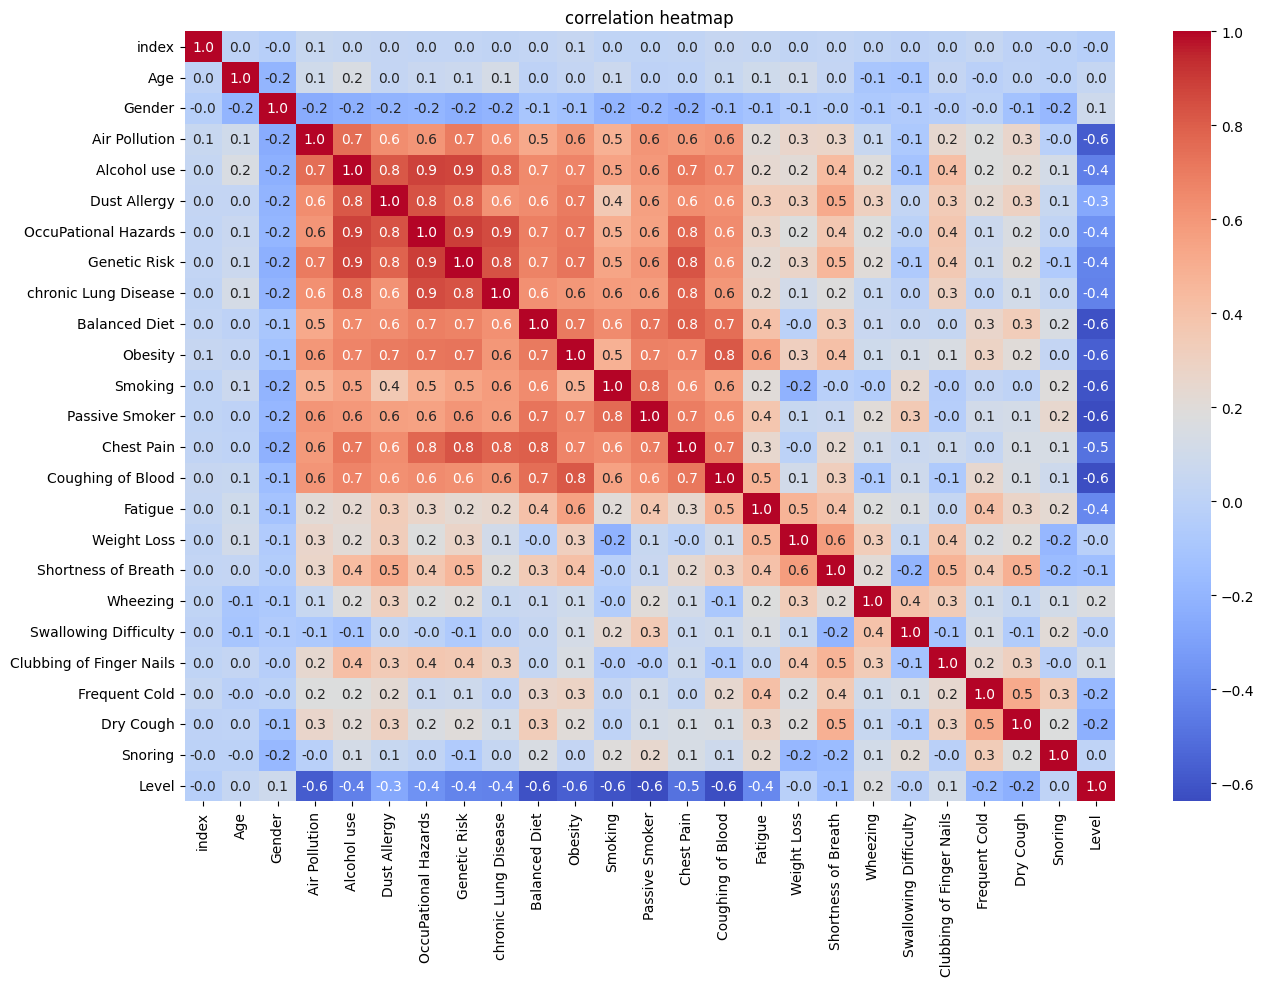

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
plt.title("correlation heatmap")
plt.show()

no feature scaling is required since all features are categorical or low-scale numerics within the 0-1 and 0-2 value ranges

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Level'])
y = df['Level']

#split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#split training further into validation (70/30)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

print("\nshapes after splitting:")
print("train:", X_train_final.shape, y_train_final.shape)
print("validation:", X_val.shape, y_val.shape)
print("test:", X_test.shape, y_test.shape)


shapes after splitting:
train: (560, 25) (560,)
validation: (240, 25) (240,)
test: (200, 25) (200,)


In [26]:
X_train_final = X_train_final.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

In [27]:
print("\nshapes after splitting:")
print("train:", X_train_final.shape, y_train_final.shape)
print("validation:", X_val.shape, y_val.shape)
print("test:", X_test.shape, y_test.shape)


shapes after splitting:
train: (560, 24) (560,)
validation: (240, 25) (240,)
test: (200, 24) (200,)


In [28]:
model = DecisionTreeClassifier()
model.fit(X_train_final, y_train_final)

y_pred = model.predict(X_test)
train_acc = model.score(X_train_final, y_train_final)
test_acc = accuracy_score(y_test, y_pred)

print(f"training Accuracy: {train_acc * 100:.2f}%")
print(f"testing Accuracy:  {test_acc * 100:.2f}%")

training Accuracy: 100.00%
testing Accuracy:  100.00%


validation set helps us tune hyperparameters and check for overfitting before testing on unseen data. it ensures the model generalizes well, not just memorizes the training data.

decision trees are not distance-based models; they split data by thresholds, so scaling (like normalization or standardization) doesn’t affect performance

#### task 04

In [30]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('task4.csv')

df

,Student,Prior Experience,Course,Time,Liked
0,1,Yes,Programming,Day,Yes
1,2,No,Programming,Day,No
2,3,Yes,History,Night,No
3,4,No,Programming,Night,Yes
4,5,Yes,English,Day,Yes
5,6,No,Programming,Day,No
6,7,Yes,Programming,Day,No
7,8,Yes,Mathematics,Night,Yes
8,9,Yes,Programming,Night,Yes
9,10,Yes,Programming,Night,No


In [36]:
from math import pow

#calculating gini impurity of a col(target)
def gini(series):
    probs = series.value_counts(normalize=True)
    g = 1 - sum(pow(p,2) for p in probs)
    return g

#calculating gini-based information gain
def gini_gain(df, feature, target):
    total_gini = gini(df[target])
    weighted_gini = 0
    
    for val in df[feature].unique():
        subset = df[df[feature] == val]
        weight = len(subset) / len(df)
        subset_gini = gini(subset[target])
        weighted_gini += weight * subset_gini
        
    ig = total_gini - weighted_gini
    return ig 

target = "Liked"
attributes = ["Prior Experience", "Course", "Time"]
gini_results = {}

print("gini gains for each attribute:\n")
for attr in attributes:
    gain = gini_gain(df, attr, target)
    gini_results[attr] = gain
    print(f"{attr:<10}: gini gain = {gain:.3f}")
    
root = max(gini_results, key=gini_results.get)
print(f"\nroot node (highest gini gain): {root}")

gini gains for each attribute:

Prior Experience: gini gain = 0.024
Course    : gini gain = 0.157
Time      : gini gain = 0.020

root node (highest gini gain): Course


in CART algorithm, **Gini Index** is used instead of entropy to measure impurity.  after calculating Gini Gains for each attribute, the feature **Course** had the highest Gini Gain, meaning it provides the most effective split for classifying whether a student “Liked” the course or not.
  
hence, the **root node of the Decision Tree** is **Course**.